# Project 3. Booking.com reviews.

### 0. Lib improt

In [120]:
#standard libs
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#text analisys
import re

#model processing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#geotools
from geopandas.tools import geocode
from haversine import haversine

#natural language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

#features influence for terget parameter
from sklearn.feature_selection import f_classif #numeric features
from sklearn.feature_selection import chi2 #category features

#category encoding
import category_encoders as ce

#feature scaling
from sklearn import preprocessing

In [2]:
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nokac\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [119]:
nltk.downloader.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nokac\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [126]:
nltk.downloader.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nokac\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [3]:
# RANDOM_SEED fixation
RANDOM_SEED = 42

In [4]:
!pip freeze > requirements_v3.txt

### 1. Data import

In [5]:
DATA_DIR = 'data/'
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv') # dataset for learning
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv') # dataset for prediction
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv') # submission

### 2. Data basic information

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
# joining datasets for correct features processing
df_train['sample'] = 1 # marking train dataset
df_test['sample'] = 0 # marking test dataset
df_test['reviewer_score'] = 0 # filling test dataset with zeros on reviewer_score feature

hotels = pd.concat(
    objs = [df_train, df_test],
    axis = 0,
    ignore_index = True
)

In [13]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
hotels.describe(include = 'all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
count,515738,515738.000000,515738,515738.000000,515738,515738,515738,515738.000000,515738.000000,515738,515738.000000,515738.000000,515738.000000,515738,515738,512470.000000,512470.000000,515738.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,NaN,55242,731,NaN,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN,NaN
freq,4789,NaN,2585,NaN,4789,245246,127890,NaN,NaN,35946,NaN,NaN,NaN,5101,2585,NaN,NaN,NaN
mean,NaN,498.081836,NaN,8.397487,NaN,NaN,NaN,18.539450,2743.743944,NaN,17.776458,7.166001,6.297672,NaN,NaN,49.442439,2.823803,0.749999
std,NaN,500.538467,NaN,0.548048,NaN,NaN,NaN,29.690831,2317.464868,NaN,21.804185,11.040228,3.902295,NaN,NaN,3.466325,4.579425,0.433014
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,0.000000,NaN,NaN,41.328376,-0.369758,0.000000
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,0.625000,NaN,NaN,48.214662,-0.143372,0.250000
50%,NaN,341.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,7.900000,NaN,NaN,51.499981,0.010607,1.000000
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.000000,9.600000,NaN,NaN,51.516288,4.834443,1.000000


### 3. Data transform

After first look at the data, one thing is certain: some columns are categorycal, and some columns should be removed.

In [143]:
#lists to collect column names
cat_columns = []
columns_to_drop = []

#### 3.1 Date (review_date/days_since_review)

In [17]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

Date since review looks like completely useless parameter.   
First, we already have ordinary review date.
Second, it has string type, and transformation is a waste of time.

In [144]:
columns_to_drop.append('days_since_review')

Day is minimal integer digit for our data. So, lets see, is there any anomalies in this scale.   
We have 731 days - two years.

Text(0, 0.5, 'Amount of rewiews')

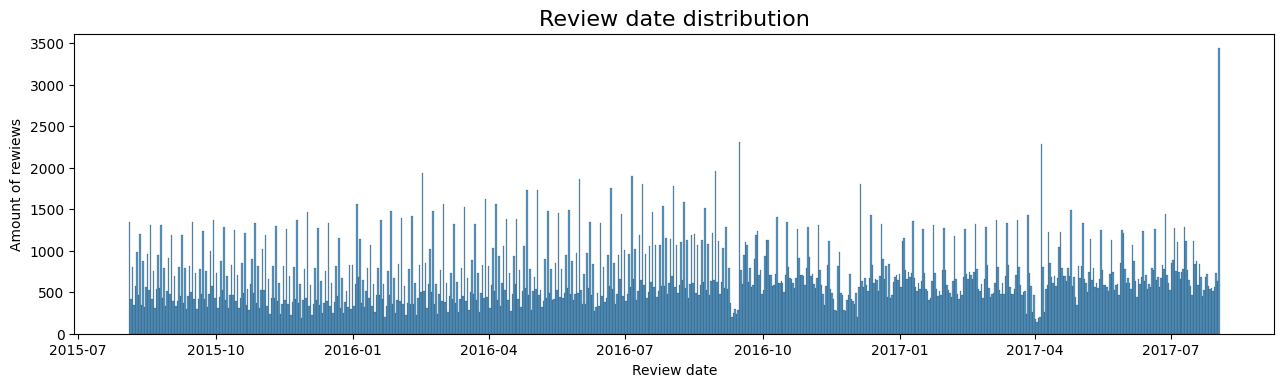

In [20]:
fig = plt.figure(figsize=(12, 3))
axes = fig.add_axes((1, 1, 1, 1))

histplot = sns.histplot(
    data = hotels,
    x='review_date', 
    bins=730,
    ax=axes,
)
histplot.set_title('Review date distribution', fontsize=16)
histplot.set_xlabel('Review date')
histplot.set_ylabel('Amount of rewiews')

We can see periods in amount of reviews in this scale. Almoust every week.

In [21]:
hotels['review_day'] = hotels['review_date'].dt.day_name()

In [22]:
review_day_groups = hotels.groupby('review_day', as_index = False).agg({
    'hotel_address': 'count'
}).rename(columns = {
    'review_day': 'day',
    'hotel_address': 'review_count'
})
review_day_groups

,day,review_count
0,Friday,44732
1,Monday,81145
2,Saturday,51833
3,Sunday,83981
4,Thursday,74508
5,Tuesday,120948
6,Wednesday,58591


Text(0, 0.5, 'Amount of rewiews')

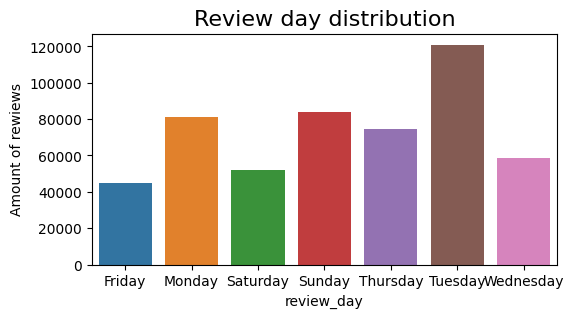

In [23]:
fig = plt.figure(figsize=(6, 3))
barplot = sns.barplot(
    data=review_day_groups,
    x = 'day',
    y = 'review_count'
    )
barplot.set_title('Review day distribution', fontsize=16)
barplot.set_xlabel('review_day')
barplot.set_ylabel('Amount of rewiews')

Day of week seems like important parameter.   
Most of the reviews are made from Sunday to Tuesday - and common sense lies behind it. Most of vacations last until Friday-Sunday. Traveller comes back home, and writes review one or two days after.

In [37]:
review_days = list(review_day_groups.sort_values(by = 'review_count', ascending = False).nlargest(3, columns = 'review_count')['day'])

In [39]:
hotels['hot_days'] = hotels['review_day'].apply(lambda x: True if x in review_days else False)

In [25]:
hotels['review_month'] = hotels['review_date'].dt.month 

In [26]:
review_month_groups = hotels.groupby('review_month', as_index = False).agg({
    'hotel_address': 'count'
}).rename(columns = {
    'review_month': 'month',
    'hotel_address': 'review_count'
})
review_month_groups.sort_values(by = 'review_count', ascending = False)

,month,review_count
7,8,50672
6,7,49318
4,5,46490
9,10,43843
5,6,42896
3,4,42883
8,9,42428
0,1,42151
2,3,41110
11,12,39607


Text(0, 0.5, 'Amount of rewiews')

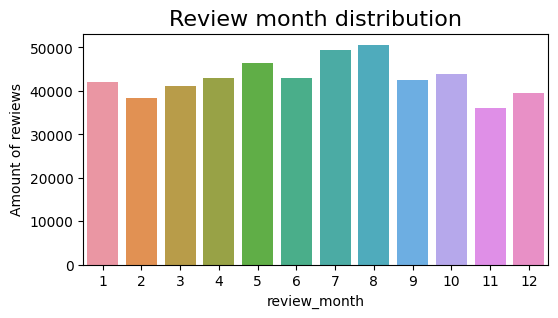

In [27]:
fig = plt.figure(figsize=(6, 3))
barplot = sns.barplot(
    data = review_month_groups,
    x = 'month',
    y = 'review_count'
    )
barplot.set_title('Review month distribution', fontsize=16)
barplot.set_xlabel('review_month')
barplot.set_ylabel('Amount of rewiews')

Same for the months - most of reviews were made in certain months.

In [35]:
hot_months = list(review_month_groups.sort_values(by = 'review_count', ascending = False).nlargest(4, columns = 'review_count')['month'])

In [40]:
hotels['hot_month'] = hotels['review_month'].apply(lambda x: True if x in hot_months else False)

In [145]:
columns_to_drop.extend(['review_month', 'review_date', 'review_day'])

#### 3.3 Hotel names (hotel_name) combined with hotel address (hotel_address)

In [42]:
hotels.groupby('hotel_name', as_index = False)['hotel_address'].agg('nunique').sort_values(by = 'hotel_address', ascending = False)

,hotel_name,hotel_address
741,Hotel Regina,3
0,11 Cadogan Gardens,1
992,Mercure Paris Gare Montparnasse,1
1001,Mercure Paris Pigalle Sacre Coeur,1
1000,Mercure Paris Opera Louvre,1
...,...,...
494,Ham Yard Hotel,1
493,Hallmark Hotel London Chigwell Prince Regent,1
492,HCC St Moritz,1
491,HCC Regente,1


In [43]:
hotels.groupby('hotel_address', as_index = False)['hotel_name'].agg('nunique').sort_values(by = 'hotel_name', ascending = False)

,hotel_address,hotel_name
722,8 Northumberland Avenue Westminster Borough Lo...,2
992,Hernalser Hauptstra e 105 17 Hernals 1170 Vien...,1
1001,Hoffingergasse 26 28 12 Meidling 1120 Vienna A...,1
1000,Hobbemakade 50 Oud Zuid 1071 XL Amsterdam Neth...,1
999,Hintschiggasse 1 10 Favoriten 1100 Vienna Austria,1
...,...,...
494,39 Avenue de l Op ra 2nd arr 75002 Paris France,1
493,39 Avenue de Wagram 17th arr 75017 Paris France,1
492,39 40 Dorset Square Hotel Westminster Borough ...,1
491,39 40 Cleveland Square Westminster Borough Lon...,1


Bingo! 3 hotels with a same name, and two hotels with a same address. We need some proper ID for our objects.

In [44]:
hotels[hotels['hotel_name'] == 'Hotel Regina']['hotel_address'].unique()

array(['Bergara 2 4 Eixample 08002 Barcelona Spain',
       'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria',
       'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'],
      dtype=object)

3 different hotels in different cities have the same name. We can add city name to hotel name to make them different.   
Now lets try to mine some more data from address - including city name, OFK.

In [45]:
hotels['hotel_address'].head(10)

0    Stratton Street Mayfair Westminster Borough Lo...
1    130 134 Southampton Row Camden London WC1B 5AF...
2     151 bis Rue de Rennes 6th arr 75006 Paris France
3    216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4            Molenwerf 1 1014 AG Amsterdam Netherlands
5                   Via Mecenate 121 20138 Milan Italy
6    97 Cromwell Road Kensington and Chelsea London...
7    Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8    190 Queen s Gate Kensington and Chelsea London...
9    Holland Park Avenue Kensington and Chelsea Lon...
Name: hotel_address, dtype: object

In [46]:
def hotel_country_city(input_string):
    """Function to transform full address to pair "country-city". Developed for specific dataset

    Args:
        input_string (string): Address, full

    Returns:
        string, string: tuple containing country name and city name
    """
    data = input_string.split(' ')
    if data[-1] == 'Kingdom':
        return data[-2] + ' ' + data[-1], data[-5]
    else:
        return data[-1], data[-2]

In [47]:
country_city = hotels['hotel_address'].apply(hotel_country_city)

country_city.value_counts()

(United Kingdom, London)    262301
(Spain, Barcelona)           60149
(France, Paris)              59928
(Netherlands, Amsterdam)     57214
(Austria, Vienna)            38939
(Italy, Milan)               37207
Name: hotel_address, dtype: int64

We have certain pairs for country and city. Let`s write them to different columns

In [55]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: hotel_country_city(x)[0])
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: hotel_country_city(x)[1])
display(hotels['hotel_country'].value_counts())
display(hotels['hotel_city'].value_counts())

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [146]:
cat_columns.extend(['hotel_country', 'hotel_city'])

In [57]:
hotels['hotel_name_unique'] = hotels.apply(lambda x: (x['hotel_name'] + ' ' + x['hotel_city']) if x['hotel_name'] == 'Hotel Regina' else x['hotel_name'], axis = 1)

In [58]:
hotels['hotel_name_unique'].nunique()

1494

In [147]:
cat_columns.append('hotel_name_unique')

In [148]:
columns_to_drop.extend(['hotel_address', 'hotel_name'])

#### 3.4 Nationality (reviewer_nationality)

In [63]:
hotels['reviewer_nationality'].nunique()

227

Lets find inner tourists.

In [67]:
hotels['inner_tourist'] = hotels.apply(lambda x: True if (x['hotel_country'] == x['reviewer_nationality'].strip()) else False, axis = 1)

In [68]:
hotels['inner_tourist'].value_counts()

False    337335
True     178403
Name: inner_tourist, dtype: int64

Also, we have way too much values. Lets try to make it less.   
The idea is to keep 95% of values, and rename other 5% to "other".

In [69]:
hotels['reviewer_nationality'].value_counts(normalize = True).nlargest(51).sum()

0.9512737087435866

In [70]:
popular_nations = hotels['reviewer_nationality'].value_counts().nlargest(51).index
hotels['rev_nation_short'] = hotels['reviewer_nationality'].apply(lambda x: x if x in popular_nations else 'Other')
hotels['rev_nation_short'] = hotels['rev_nation_short'].apply(lambda x: x.strip())

In [149]:
cat_columns.append('rev_nation_short')
columns_to_drop.append('reviewer_nationality')

#### 3.5 Tags (tags)

In [72]:
def tag_split(input_string):
    """Function to transform string with tags into set of tags without useless symbols

    Args:
        input_string (string): string of tags with useless symbols
    Returns:
        float: _NaN for empty cells
        set: set of tags
    """
    if (input_string is np.nan):
        return np.nan
    
    tag_list = input_string[1:-1].lower().split(',')
    for i,tag in enumerate(tag_list):
        tag_list[i] = tag.strip().replace('\'','').strip()
    
    return set(tag_list)

In [73]:
Tags = hotels['tags'].apply(tag_split)
tag_set= set()
for tag in Tags:
    tag_set.update(tag)
print('Overall tags:',len(tag_set))

Overall tags: 2421


In [74]:
tag_dict = dict.fromkeys(tag_set)

for tag_string in hotels['tags']:
    for item in tag_split(tag_string):
        if tag_dict[item] is None:
            tag_dict[item] = 1
        else:
            tag_dict[item] += 1

sorted(tag_dict.items(), key = lambda x: x[1], reverse = True)[0]

('leisure trip', 417778)

In [75]:
sorted_tags = sorted(tag_dict.items(), key = lambda x: x[1], reverse = True)

In [76]:
display(sorted_tags)

[('leisure trip', 417778),
 ('submitted from a mobile device', 307640),
 ('couple', 252294),
 ('stayed 1 night', 193645),
 ('stayed 2 nights', 133937),
 ('solo traveler', 108545),
 ('stayed 3 nights', 95821),
 ('business trip', 82939),
 ('group', 65392),
 ('family with young children', 61015),
 ('stayed 4 nights', 47817),
 ('double room', 35207),
 ('standard double room', 32248),
 ('superior double room', 31393),
 ('family with older children', 26349),
 ('deluxe double room', 24823),
 ('double or twin room', 22393),
 ('stayed 5 nights', 20845),
 ('standard double or twin room', 17483),
 ('classic double room', 16989),
 ('superior double or twin room', 13570),
 ('2 rooms', 12393),
 ('stayed 6 nights', 9776),
 ('standard twin room', 9745),
 ('single room', 9670),
 ('twin room', 8321),
 ('stayed 7 nights', 7399),
 ('executive double room', 6425),
 ('classic double or twin room', 6107),
 ('superior twin room', 6064),
 ('deluxe double or twin room', 6009),
 ('club double room', 5908),
 ('qu

##### 3.5.1 Stayed nights

In [77]:
hotels['nights_stayed'] = hotels['tags'].apply(lambda x: int(x.lower().split(' ')[x.lower().split(' ').index('stayed') + 1]) if 'stayed' in x.lower().split(' ') else 1)

In [78]:
nights_stayed_groups = hotels.groupby('nights_stayed', as_index = False).agg({
    'hotel_name_unique': 'count'
}).rename(columns = {
    'nights_stayed': 'nights',
    'hotel_name_unique': 'review_count'
})
nights_stayed_groups.sort_values(by = 'review_count', ascending = False)

,nights,review_count
0,1,193837
1,2,133937
2,3,95821
3,4,47817
4,5,20845
5,6,9776
6,7,7399
7,8,2502
8,9,1293
9,10,889


Text(0, 0.5, 'Amount of rewiews')

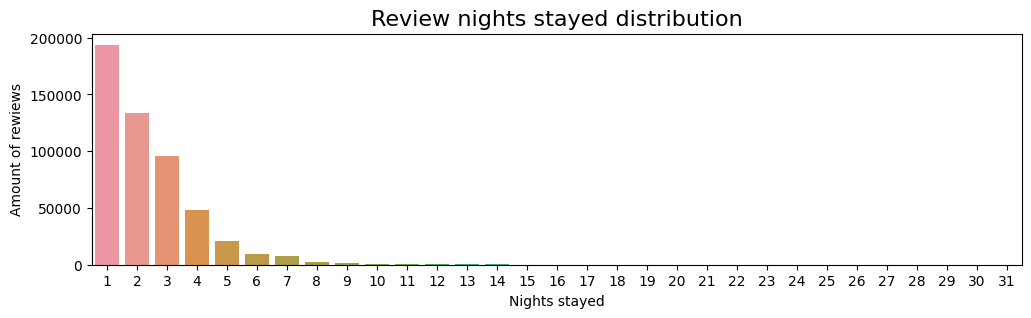

In [79]:
fig = plt.figure(figsize=(12, 3))
barplot = sns.barplot(
    data = nights_stayed_groups,
    x = 'nights',
    y = 'review_count'
    )
barplot.set_title('Review nights stayed distribution', fontsize=16)
barplot.set_xlabel('Nights stayed')
barplot.set_ylabel('Amount of rewiews')

##### 3.5.2 Pets

In [80]:
pet_tags = []
for pair in sorted_tags:
    if ('pet' in pair[0]) and ('petite' not in pair[0]):
        pet_tags.append(pair)
        
display(pet_tags)

[('with a pet', 1405)]

In [81]:
def pet_func(input_string):
    """Function to detect pet in visiters groups.

    Args:
        input_string (string): All tags from review

    Returns:
        bool: Pet status
    """
    for pair in pet_tags:
        if pair[0] in input_string.lower():
            return True #with pet
    return False #without pet

In [82]:
hotels['with_pet'] = hotels['tags'].apply(pet_func)

##### 3.5.3 Trip type

In [83]:
trip_tags = []
for pair in sorted_tags:
    if 'trip' in pair[0] and 'triple' not in pair[0]:
        trip_tags.append(pair)
        
display(trip_tags)

[('leisure trip', 417778), ('business trip', 82939)]

Let`s focus on simple question - was reviewers trip business or not?

In [84]:
def trip_func(input_string):
    """Function to detect trip type

    Args:
        input_string (string): All tags from review

    Returns:
        int: trip type - 1 for leisure, 0 for business, 2 to unknown
    """
    if trip_tags[0][0] in input_string.lower():
        return False
    elif trip_tags[1][0] in input_string.lower():
        return True
    else:
        return False #for tags without trip type information - filling them with mode value

In [85]:
hotels['trip_type'] = hotels['tags'].apply(trip_func)

In [86]:
hotels['trip_type'].value_counts()

False    432799
True      82939
Name: trip_type, dtype: int64

##### 3.5.4 From mobile

In [87]:
mobile_tags = []
for pair in sorted_tags:
    if 'mobile device' in pair[0]:
        mobile_tags.append(pair)
        
display(mobile_tags)

[('submitted from a mobile device', 307640)]

In [88]:
def mobile_func(input_string):
    """Function to detect review from mobile device

    Args:
        input_string (string): All tags from review

    Returns:
        bool: From mobile device or not
    """
    for pair in mobile_tags:
        if pair[0] in input_string.lower():
            return True #review from mobile device
    return False

In [89]:
hotels['from_mobile'] = hotels['tags'].apply(mobile_func)

##### 3.5.5 Room capacity and class

In [90]:
def child_search(input_string):
    """Function to collect given amount of children from tags

    Args:
        input_string (string): All tags from review

    Returns:
        int: amount of children
    """
    target = re.findall(r'\d [cC]hildren', input_string)
    if len(target) > 0:
        return int(target[-1][0])
    if 'children' in input_string:
        return 1
    return 0   

In [91]:
#classification of room capacity except additional children beds
room_capacity = [
    ['unknown'],
    ['single', 'solo'],
    ['double', 'twin', 'couple', '2 rooms', 'two'],
    ['family', 'triple'],
    ['two bedroom', 'travelers with friends']
    ]

In [92]:
def capacity_func(input_string):
    j = 0
    for i, cap in enumerate(room_capacity):
        for type in cap:
            if type in input_string.lower():
                j = i
    if 'children' in input_string.lower():
        j = 2 + child_search(input_string)
    if 'group' in input_string.lower():
        j = 2 #most of tags has 2 rooms or standard room        
    return j

In [93]:
hotels['room_capacity'] = hotels['tags'].apply(capacity_func)

In [94]:
hotels['room_capacity'].value_counts(dropna = False)

2    384827
3     87584
1     39574
4      3724
5        29
Name: room_capacity, dtype: int64

In [95]:
#room class classification
room_class = [
    ['unknown'],
    ['compact', 'economy', 'small', 'queen', 'camper', 'mini', 'bunk bed'],
    ['basic', 'classic', 'studio', 'standard', 'ordinary', 'city', 'classique'],
    ['superior', 'comfort', 'club', 'modern', 'art', 'king', 'wonderful', 'view', 'loft', 'panoramic', 'cosy', 'intuition', 'fabulous', 'mega', 'cool corner', 'ambassador',
     'cozy', 'emotion', 'large'],
    ['executive', 'hilton', 'romantic', 'special', 'business', 'garden', 'spectacular', 'atrium', 'sensation', 'terrace', 'prestige'],
    ['maisonette', 'penthouse', 'privilege', 'penta', 'premier', 'premium', 'mandarin', 'suite', 'deluxe', 'luxury']
    ]

In [96]:
def class_func(input_string):
    """Function to encode room class

    Args:
        input_string (string): All tags from review

    Returns:
        int: room class code
    """
    j = 0
    for i, cap in enumerate(room_class):
        for type in cap:
            if type in input_string.lower():
                j = i  
    if j == 0:
        j = 2 #for atomised types
    return j

In [97]:
hotels['room_class'] = hotels['tags'].apply(class_func)

In [98]:
hotels['room_class'].value_counts(dropna = False)

2    206243
3    109076
4     92446
5     90099
1     17874
Name: room_class, dtype: int64

Thats all we could get from tags. Time to say goodbuy!

In [150]:
columns_to_drop.append('tags')

#### 3.6 Latitude/longitude (lat/lng)
As far as we have city name for all entities, we can calculate distance between city center and hotel - it seems like important parameter for travelers.   
Before this calculation, we can fill emply cells with special librarys Geopy and Geopandas.

In [100]:
lat_list = list(hotels[hotels['lat'].isnull()].groupby('hotel_name', as_index = False)['lat'].mean()['hotel_name'])

In [101]:
lat_df = geocode(lat_list, provider = 'nominatim', user_agent = 'my_request')

In [102]:
lat_df['hotel_name'] = lat_list

In [103]:
lat_df

,geometry,address,hotel_name
0,POINT EMPTY,None,Austria Trend Hotel Schloss Wilhelminenberg Wien
1,POINT EMPTY,None,City Hotel Deutschmeister
2,POINT (16.35143 48.20966),"Cordial Theaterhotel, 22, Josefstädter Straße,...",Cordial Theaterhotel Wien
3,POINT EMPTY,None,Derag Livinghotel Kaiser Franz Joseph Vienna
4,POINT EMPTY,None,Fleming s Selection Hotel Wien City
5,POINT (2.34366 48.87157),"Holiday Inn Paris Opéra, Boulevard Poissonnièr...",Holiday Inn Paris Montmartre
6,POINT (84.89058 27.91122),"Bhairab Hotel and Lodge, Dhading Besi Marga, F...",Hotel Advance
7,POINT (4.35441 50.85207),"Hôtel Atlanta, Passage du Nord - Noorddoorgang...",Hotel Atlanta
8,POINT (16.37992 48.21357),"Hotel City-Central, 8, Taborstraße, Karmeliter...",Hotel City Central
9,POINT (16.38385 48.18886),"Daniel, 5, Landstraßer Gürtel, Fasanviertel, K...",Hotel Daniel Vienna


Not all the POINTS are full, and also not all of them are correct. Sad, but true - and better than nothing.

In [104]:
lat_df_points = lat_df.drop(labels = [0, 1, 3, 4, 6, 7, 10, 11, 12, 13], axis = 0).reset_index(drop=True)

In [105]:
for index, raw in lat_df_points.iterrows():
    
    hotels.loc[(hotels.hotel_name == lat_df_points.hotel_name.iloc[index]), ('lat', 'lng')] = (lat_df_points.geometry.iloc[index].y,lat_df_points.geometry.iloc[index].x) 

Not all of empty cell were filled. We can fill empty distance between hotel and city cells center after calculation with median for the current city.

In [106]:
cities_center = {
    'London': (51.509865, -0.118092),
    'Paris': (48.864716, 2.349014),
    'Milan': (45.464664, 9.188540),
    'Amsterdam': (52.379189, 4.899431),
    'Barcelona': (41.390205, 2.154007),
    'Vienna': (48.210033, 16.363449)
    }

In [107]:
def dist_to_city_center(lat, lng, city):
    """Function to calculate distance to city center from point with current coordinates

    Args:
        lat (float): Latitude, decimal degree
        lng (float): longitude, decimal degree
        city (string): City name

    Returns:
        float: distance, km
    """
    if city in cities_center.keys():
        dist = haversine(cities_center[city], (lat, lng))
    else:
        dist = np.nan
    return dist

In [108]:
hotels['dist_to_city_center'] = hotels.apply(lambda x: dist_to_city_center(x['lat'], x['lng'], x['hotel_city']), axis = 1)

In [109]:
mask1 = hotels['dist_to_city_center'].isnull()
for index, raw in hotels[mask1].iterrows():
    mask2 = hotels['hotel_city'] == raw.hotel_city
    hotels.loc[index, 'dist_to_city_center'] = hotels[mask2]['dist_to_city_center'].median()

Text(0, 0.5, 'Amount of rewiews')

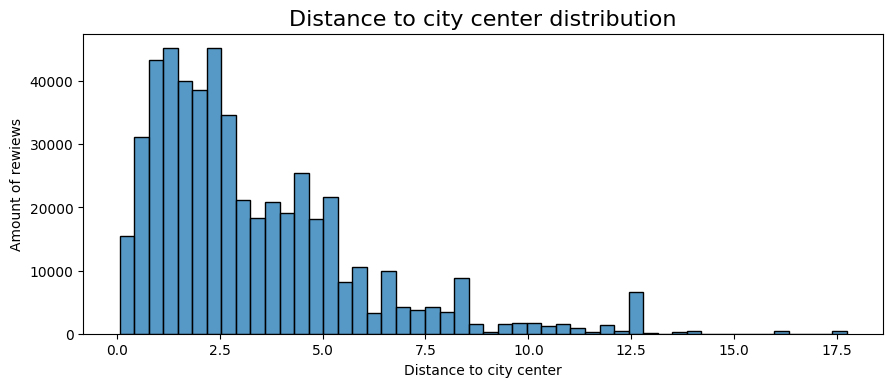

In [110]:
fig = plt.figure(figsize=(8, 3))
axes = fig.add_axes((1, 1, 1, 1))

histplot = sns.histplot(
    data = hotels,
    x='dist_to_city_center', 
    bins=50,
    ax=axes,
)
histplot.set_title('Distance to city center distribution', fontsize=16)
histplot.set_xlabel('Distance to city center')
histplot.set_ylabel('Amount of rewiews')

In [151]:
columns_to_drop.extend(['lat', 'lng'])

#### 3.7 Positive and negative reviews (positive_review/negative_review)
First, we need to examine most common values.

In [112]:
hotels['negative_review_sl'] = hotels['negative_review'].apply(lambda x: x.lower().strip())

In [113]:
hotels['negative_review_sl'].value_counts().nlargest(30)

no negative                  127890
nothing                       21185
n a                            1815
none                           1501
                                849
nothing really                  656
small room                      570
all good                        545
breakfast                       545
no complaints                   523
location                        502
nothing at all                  467
everything                      420
nothing to dislike              373
price                           348
nil                             332
small rooms                     307
everything was perfect          276
na                              272
can t think of anything         250
leaving                         244
absolutely nothing              242
everything was great            222
expensive                       206
nothing to complain about       205
no                              200
room size                       200
very small room             

We can make a list of strings for reviews where were no negative experience.   

In [114]:
no_negative_list = ['no negative','nothing','n a','none','nothing really','all good','no complaints','nothing at all','nothing to dislike',
                    'nil','na','everything was perfect','absolutely nothing','can t think of anything','leaving','everything was great','nothing to complain about',
                    'no','nothing not to like','everything was good','nothing all good','having to leave','not much','i liked everything','liked everything',
                    'nothing everything was perfect','non','nothing it was perfect','everything was fine','nothing everything was great',
                    'all was good','nothing in particular','there was nothing i didn t like','nothing comes to mind','']

In [115]:
hotels['positive_review_sl'] = hotels['positive_review'].apply(lambda x: x.lower().strip())

In [116]:
hotels['positive_review_sl'].value_counts().nlargest(30)

no positive                   35946
location                      11945
everything                     3314
nothing                        1731
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
everything was perfect          316
good breakfast                  316
location was good               312
comfy bed                       303
perfect location                287
the staff                       281
location is great               280
location is good                256
all                             250
clean                           237
every thing                     235
very friendly staff             233
great breakfast             

The same with above, we can make a list of strings for reviews without positive experience.   
Need to say, it is way shorter!

In [117]:
no_positive_list = ['no positive','nothing']

Ignoring obvious reviews, and using Natural Language Toolkit library (nltk), we can evaluate review.   
Negative as same as positive.

In [132]:
stop_words=stopwords.words('english')
review_analyser = SentimentIntensityAnalyzer()

In [133]:
def neg_func(input_string):
    """Function to evaluate negative review

    Args:
        input_string (string): Negative review text

    Returns:
        float: Review score (compound)
    """
    if input_string in no_negative_list:
        return 0
    else:
        no_sw_string = ' '.join([word for word in input_string.split() if word not in stop_words])
        tok_string = sent_tokenize(no_sw_string)
        text_string = ' '.join(tok_string)
        review_scores = review_analyser.polarity_scores(text_string)
        return review_scores['compound']

In [134]:
hotels['negative_review_com'] = hotels['negative_review_sl'].apply(neg_func)

Text(0, 0.5, 'Amount of rewiews')

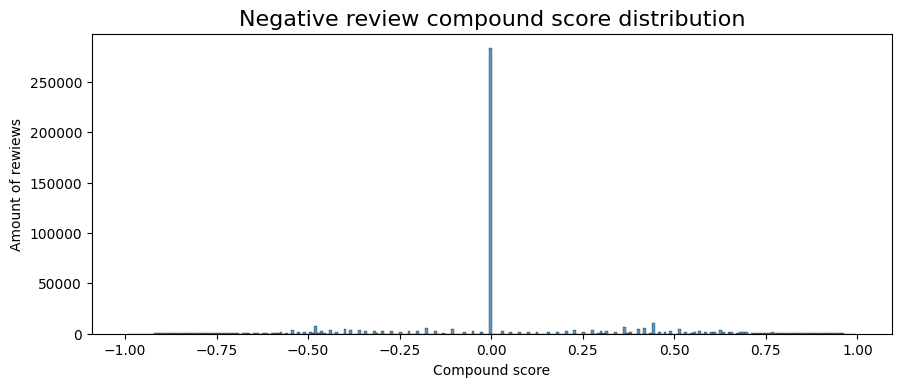

In [135]:
fig = plt.figure(figsize=(8, 3))
axes = fig.add_axes((1, 1, 1, 1))

histplot = sns.histplot(
    data = hotels,
    x='negative_review_com', 
    bins=250,
    ax=axes,
)
histplot.set_title('Negative review compound score distribution', fontsize=16)
histplot.set_xlabel('Compound score')
histplot.set_ylabel('Amount of rewiews')

In [136]:
def pos_func(input_string):
    """Function to evaluate positive review

    Args:
        input_string (string): Positive review text

    Returns:
        float: Review score (compound)
    """
    if input_string in no_positive_list:
        return 0
    else:
        no_sw_string = ' '.join([word for word in input_string.split() if word not in stop_words])
        tok_string = sent_tokenize(no_sw_string)
        text_string = ' '.join(tok_string)
        review_scores = review_analyser.polarity_scores(text_string)
        return review_scores['compound']

In [137]:
hotels['positive_review_com'] = hotels['positive_review_sl'].apply(pos_func)

Text(0, 0.5, 'Amount of rewiews')

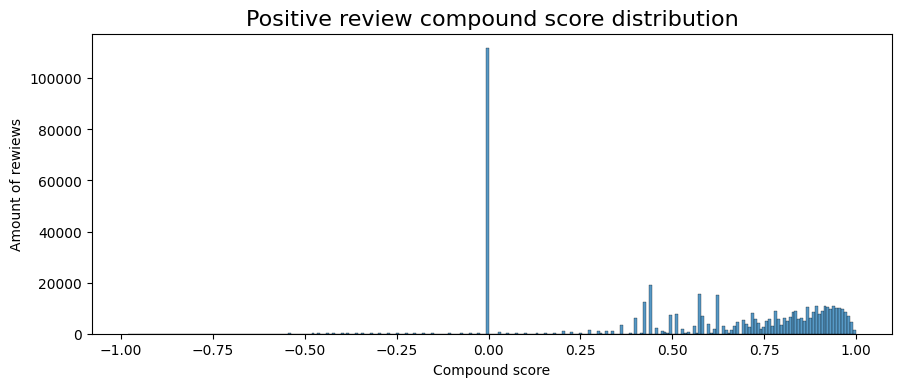

In [138]:
fig = plt.figure(figsize=(8, 3))
axes = fig.add_axes((1, 1, 1, 1))

histplot = sns.histplot(
    data = hotels,
    x='positive_review_com', 
    bins=250,
    ax=axes,
)
histplot.set_title('Positive review compound score distribution', fontsize=16)
histplot.set_xlabel('Compound score')
histplot.set_ylabel('Amount of rewiews')

As far as we are adding artificial zeros into our estimation, let`s check significance of calculated values - with zeros and without them.

<AxesSubplot: >

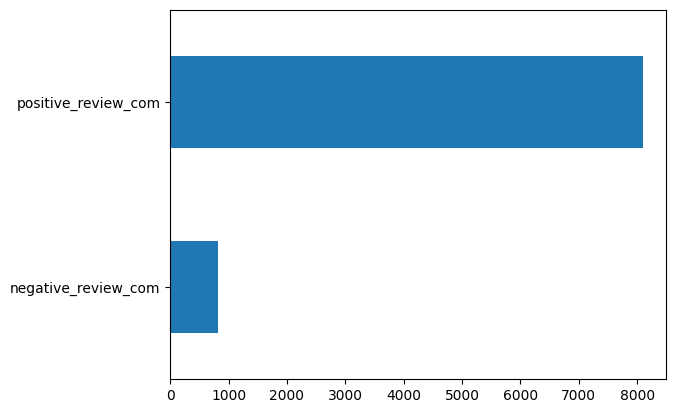

In [139]:
y = hotels['reviewer_score']
y = y.astype('int')

val_columns = ['negative_review_com', 'positive_review_com']

imp_num = pd.Series(f_classif(hotels[val_columns], y)[0], index = val_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot: >

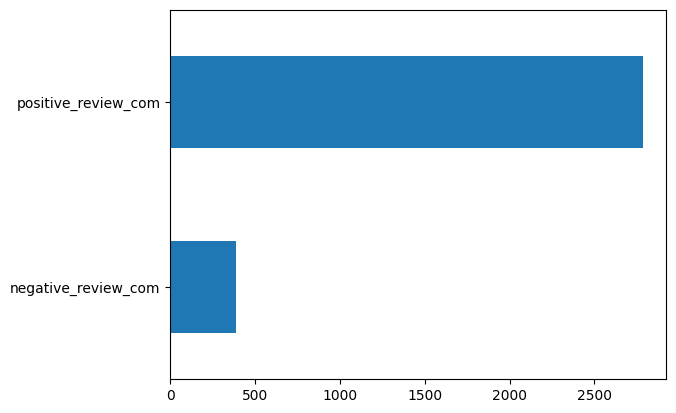

In [140]:
mask_zeros = (hotels['negative_review_com'] != 0) & (hotels['positive_review_com'] != 0)

y = hotels[mask_zeros]['reviewer_score']
y = y.astype('int')

val_columns = ['negative_review_com', 'positive_review_com']

imp_num = pd.Series(f_classif(hotels[mask_zeros][val_columns], y)[0], index = val_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Now we see, that artificial zeros are good enough - without them new features are less significante.

In [152]:
columns_to_drop.extend(['negative_review', 'negative_review_sl', 'positive_review', 'positive_review_sl'])

#### 3.8 Encoding categories

In [153]:
cat_columns

['hotel_country', 'hotel_city', 'hotel_name_unique', 'rev_nation_short']

hotel_name_unique - 1494 values, exclude from encoding
hotel_city - 6 values, one hot encoder; hotel_country - exclude from encoding since 1.0 correlation with hotel_city
rev_nation_short - 51 values, binary encoder   

In [154]:
encoder_oh = ce.OneHotEncoder(cols=['hotel_city'])
hotels_oh = encoder_oh.fit_transform(hotels[['hotel_city']]).astype('bool')
hotels = hotels.join(
    hotels_oh,
    how = 'left'
)

In [155]:
encoder_bin = ce.BinaryEncoder()
hotels_bin = encoder_bin.fit_transform(hotels[['rev_nation_short']]).astype('bool')
hotels = hotels.join(
    hotels_bin,
    how = 'left'
)

After encoding is done, we could delete category columns.

In [156]:
columns_to_drop.extend(cat_columns)

#### 3.9 Cleanup

In [157]:
hotels_copy = hotels.copy()

In [158]:
columns_to_drop

['days_since_review',
 'review_month',
 'review_date',
 'review_day',
 'hotel_address',
 'hotel_name',
 'reviewer_nationality',
 'tags',
 'lat',
 'lng',
 'negative_review',
 'negative_review_sl',
 'positive_review',
 'positive_review_sl',
 'hotel_country',
 'hotel_city',
 'hotel_name_unique',
 'rev_nation_short']

In [159]:
hotels_copy.drop(columns_to_drop, axis = 1, inplace = True)

From previous tryes - 'with_pet' is uniportant.

In [177]:
hotels_copy.drop('with_pet', axis = 1, inplace = True)

#### 4. Correlation

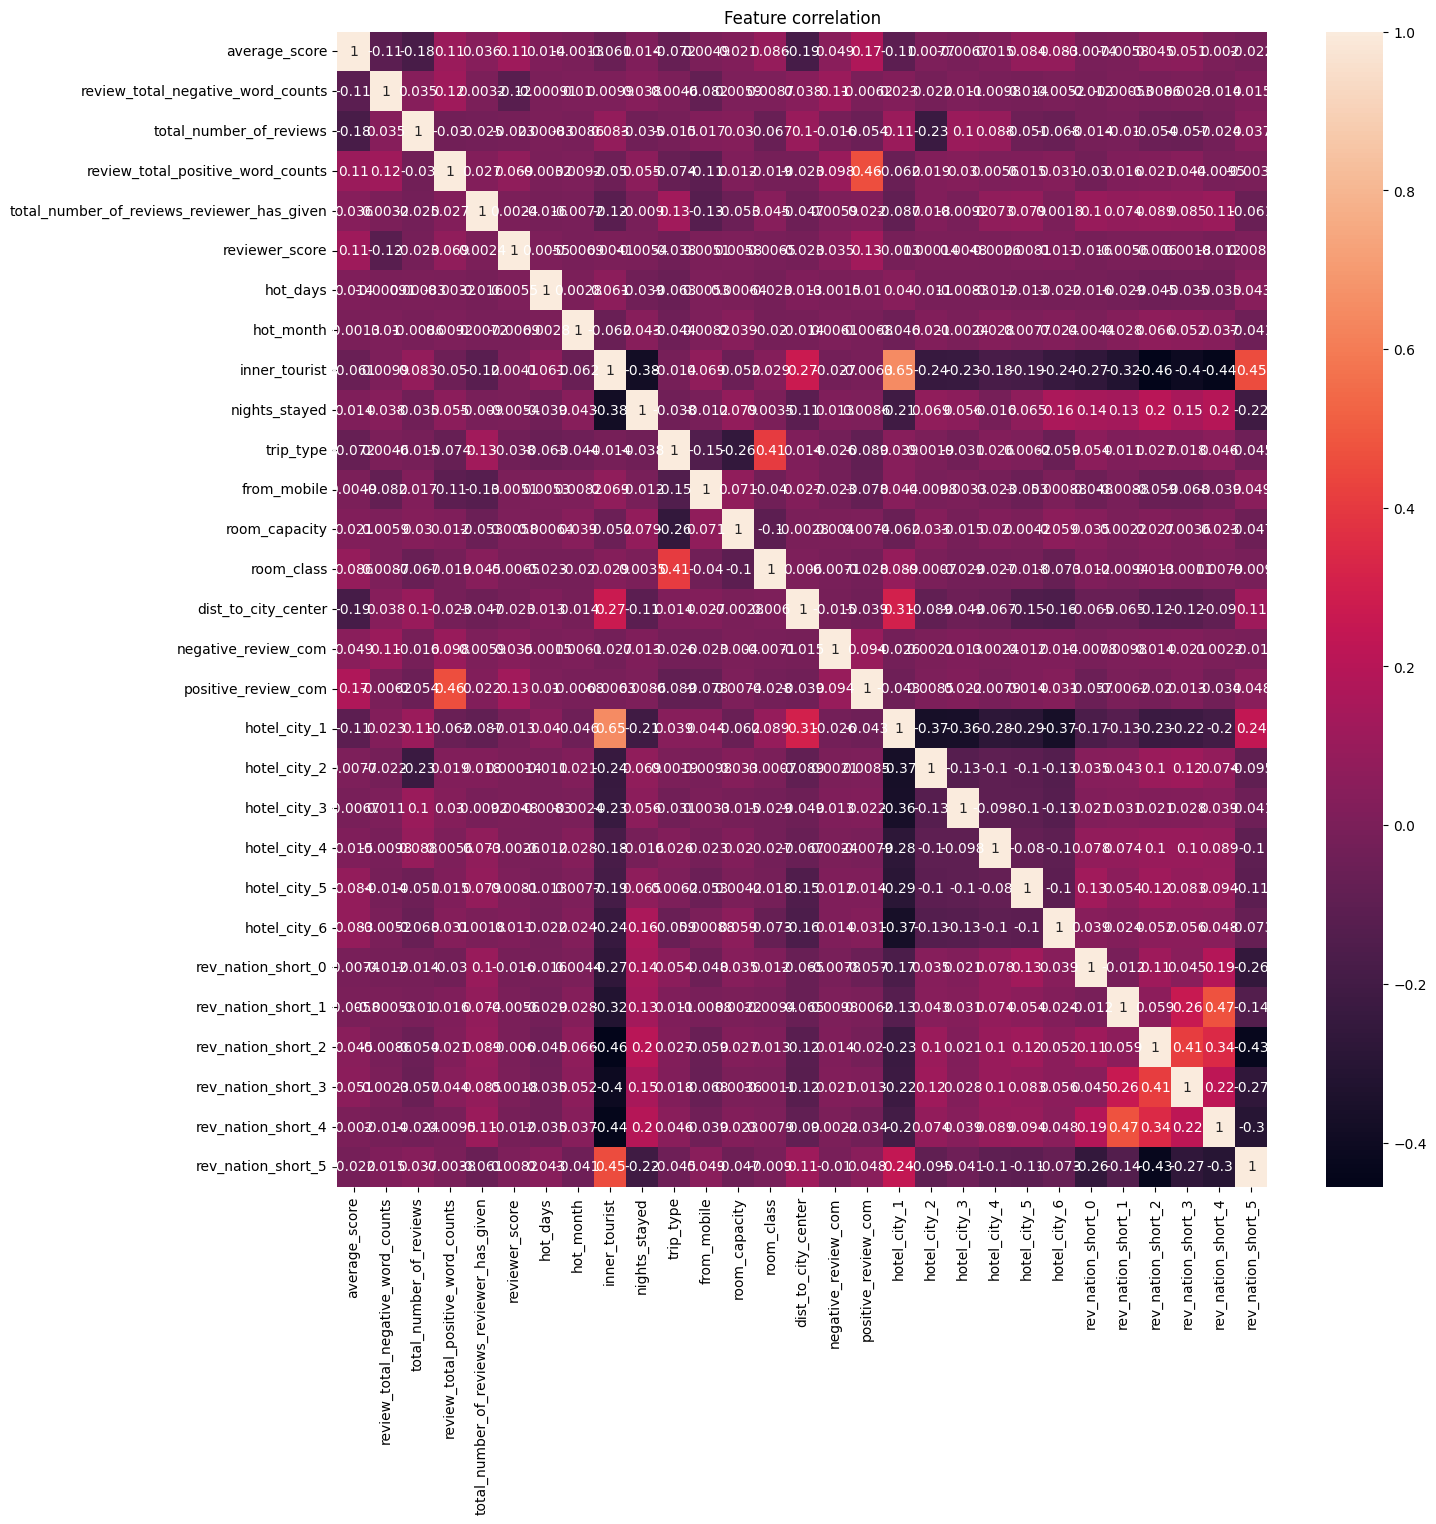

In [178]:
fig = plt.figure(figsize=(15, 15))

ax = sns.heatmap(hotels_copy.drop(['sample'], axis=1).corr(), annot = True)
ax.set_title("Feature correlation")
plt.xticks(rotation = 90)

plt.show()

Lets drop highly (>0.7) correlated features!   
additional_number_of_scoring - thus are scores without reviews. They are included into total number of reviews. Importance comparasion is below.   

<AxesSubplot: >

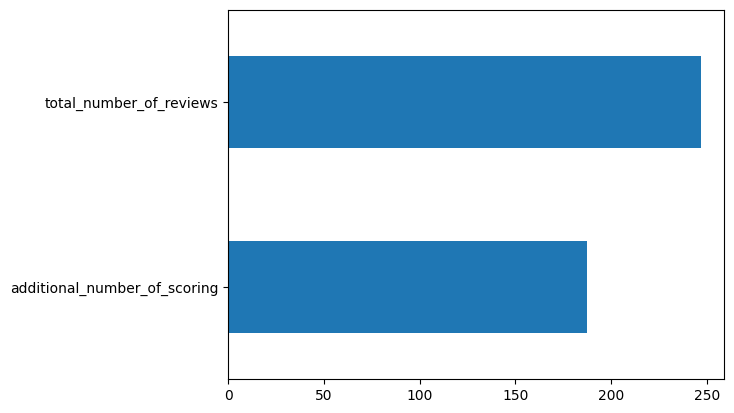

In [162]:
y = hotels_copy['reviewer_score']
y = y.astype('int')

val_columns = ['additional_number_of_scoring', 'total_number_of_reviews']

imp_num = pd.Series(f_classif(hotels_copy[val_columns], y)[0], index = val_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [163]:
hotels_copy.drop(['additional_number_of_scoring'], axis = 1, inplace = True)

#### 5. Feature scaling

In [165]:
num_columns = [s for s in hotels_copy.columns if hotels[s].dtypes != 'bool']
num_columns.remove('negative_review_com')
num_columns.remove('positive_review_com')
num_columns.remove('room_capacity')
num_columns.remove('room_class')
num_columns.remove('sample')

num_columns

['average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'nights_stayed',
 'dist_to_city_center']

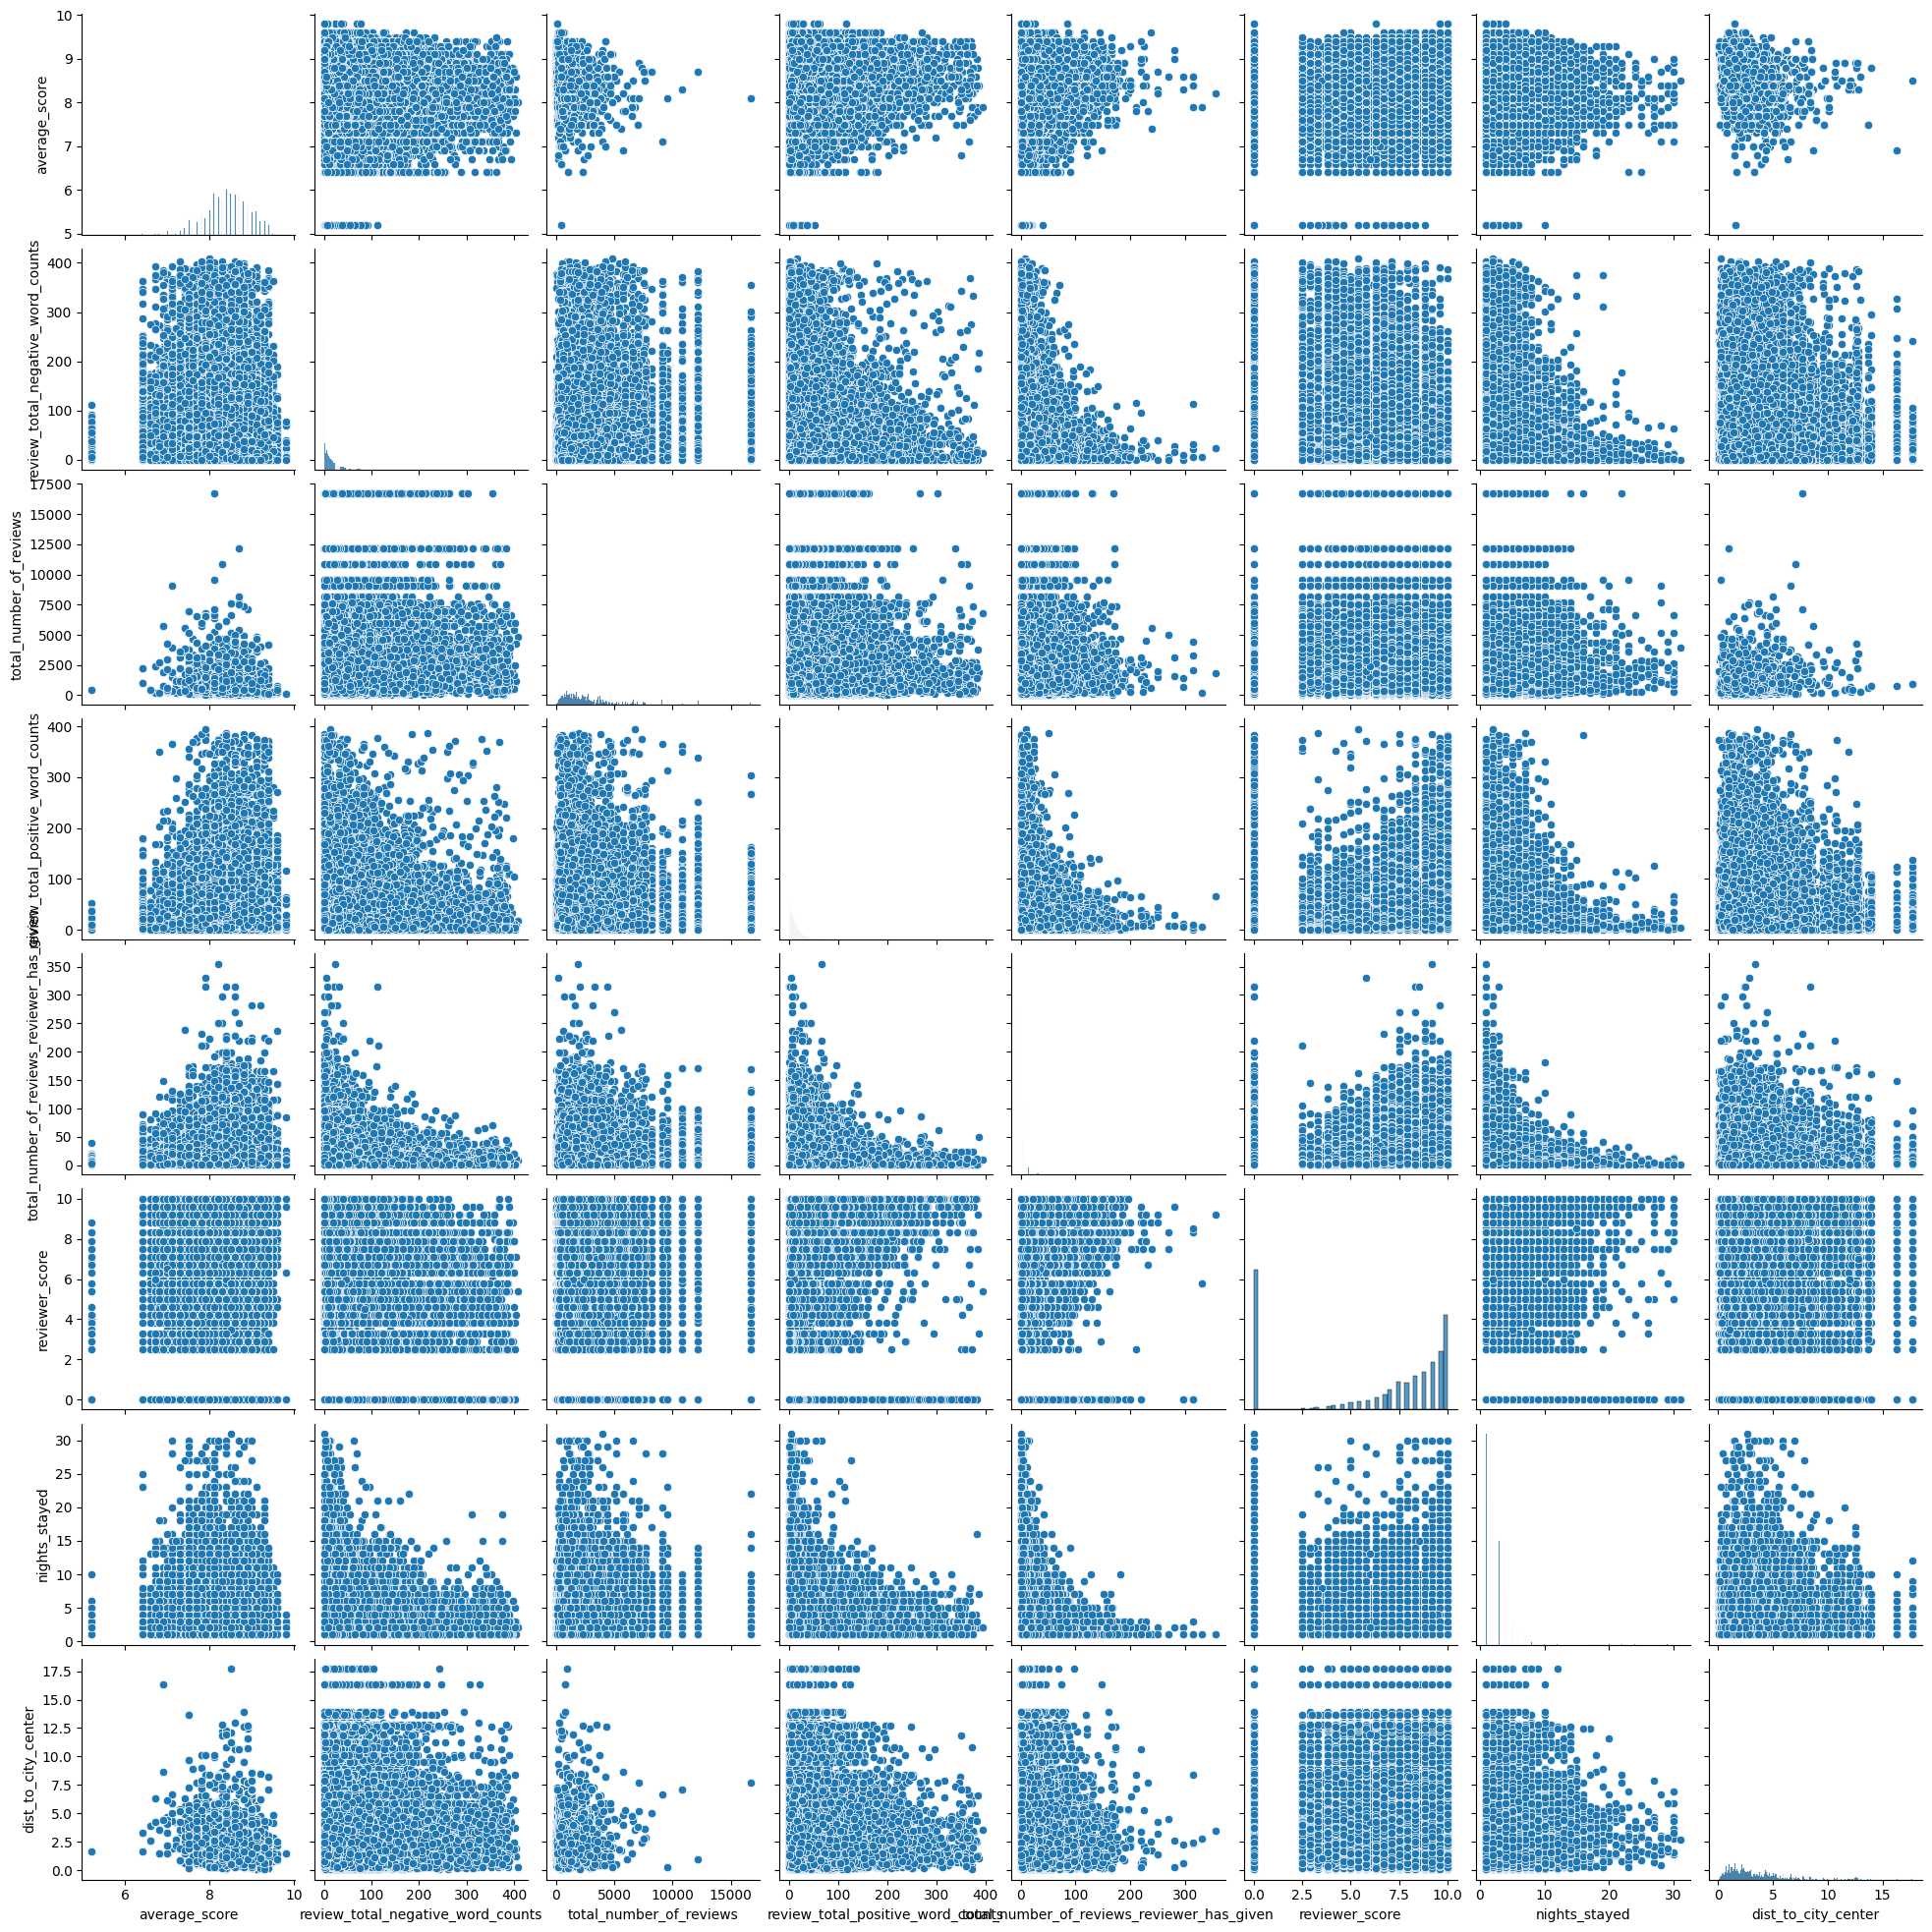

In [166]:
sns.pairplot(hotels_copy[num_columns])

"average_score" feature distributed normally and needs standartisation.   
Other features needs normalisation. We don`t touch outlyers earlyer, so we will use Robust Scaler for that.   
'reviewer_score' will stay as it is.   
The same - for 'nights_stayed'.

In [167]:
r_scaler = preprocessing.RobustScaler()
norm_columns = [
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',   
    'dist_to_city_center'
    ]

hotels_norm = r_scaler.fit_transform(hotels_copy[norm_columns])
hotels_norm = pd.DataFrame(hotels_norm, columns = norm_columns)

hotels_copy[norm_columns] = hotels_norm[norm_columns]

In [168]:
s_scaler = preprocessing.StandardScaler()

std_columns = ['average_score']
hotels_stand = s_scaler.fit_transform(hotels_copy[std_columns])
hotels_stand = pd.DataFrame(hotels_stand, columns = std_columns)

hotels_copy[std_columns] = hotels_stand[std_columns]

#### 6. Mashine learning

In [179]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  float64
 2   total_number_of_reviews                     515738 non-null  float64
 3   review_total_positive_word_counts           515738 non-null  float64
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  float64
 5   reviewer_score                              515738 non-null  float64
 6   sample                                      515738 non-null  int64  
 7   hot_days                                    515738 non-null  bool   
 8   hot_month                                   515738 non-null  bool   
 9   inner_tourist                               515738 non-null  bool   
 

In [180]:
# separating test part
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis = 1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis = 1)

y = train_data.reviewer_score.values            # our target
X = train_data.drop(['reviewer_score'], axis=1)

In [181]:
# Datasets labeled "train" will be used for training the model, "test" for testing.
# For testing, we will use 20% of the original dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = RANDOM_SEED)

In [182]:
# checkup
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 29), (386803, 29), (386803, 28), (309442, 28), (77361, 28))

In [183]:
# Create a model
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state = RANDOM_SEED)  
      
# Train the model on the test dataset
regr.fit(X_train, y_train)  
      
# Use the trained model to predict the rating of hotels in the test set. 
# The predicted values are written to the variable y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished


In [184]:
# Compare the predicted values (y_pred) with the real values (y_test), and see how they differ
# The metric is called Mean Absolute Percentage Error (MAPE) and shows the average absolute percentage error of the predicted values from the actual ones.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1276910127699419


<AxesSubplot: >

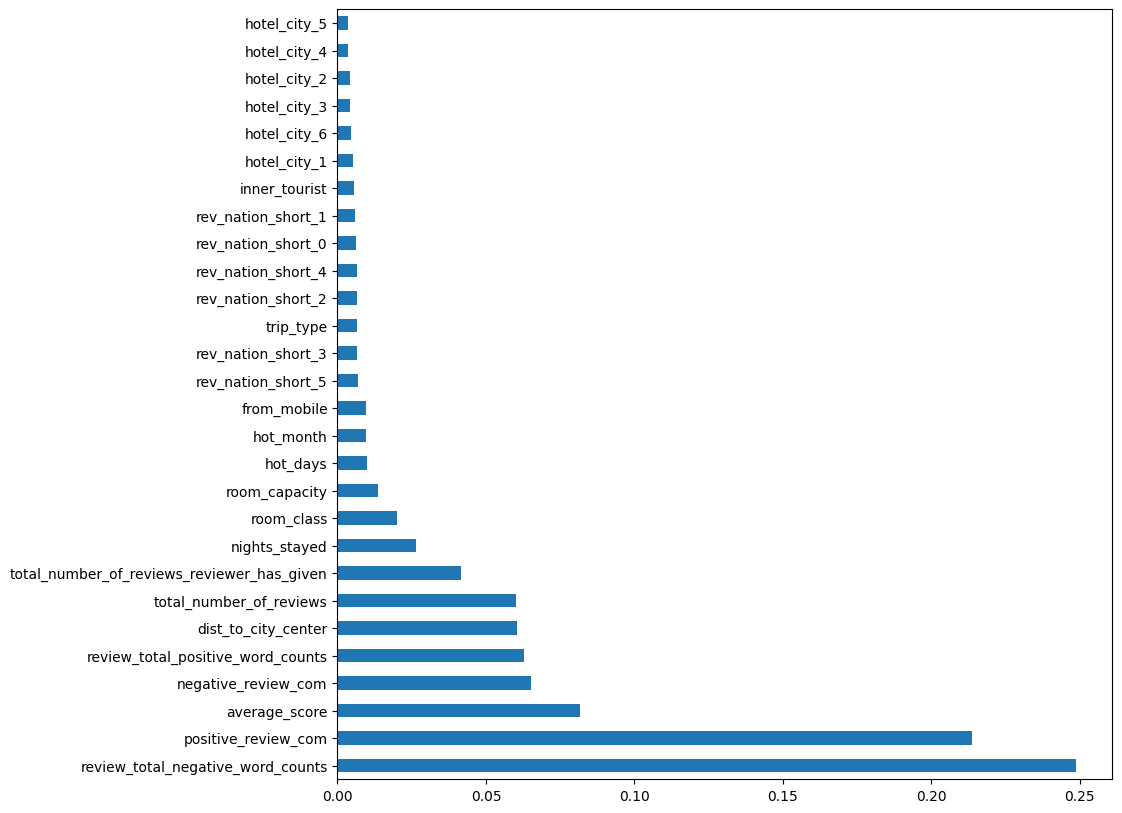

In [185]:
# in RandomForestRegressor it is possible to display the most important features for the model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(31).plot(kind='barh')

In [186]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hot_days,hot_month,inner_tourist,nights_stayed,...,hotel_city_3,hotel_city_4,hotel_city_5,hotel_city_6,rev_nation_short_0,rev_nation_short_1,rev_nation_short_2,rev_nation_short_3,rev_nation_short_4,rev_nation_short_5
488806,0.916915,1.952381,-0.647635,2.235294,0.142857,0.0,False,False,False,4,...,False,False,False,True,False,False,True,True,False,False
438296,0.369517,-0.428571,1.002855,0.529412,0.000000,0.0,True,True,False,2,...,True,False,False,False,False,True,False,True,True,False
498977,-0.725278,-0.190476,0.299347,-0.176471,0.000000,0.0,False,False,False,5,...,False,False,False,False,False,False,True,False,False,True
499300,-1.090210,0.380952,1.554241,-0.352941,0.000000,0.0,True,True,False,3,...,False,False,False,False,False,True,False,False,True,False
387476,-2.732403,2.333333,1.471452,0.176471,0.428571,0.0,True,False,False,3,...,False,True,False,False,False,False,False,False,True,True
394881,-0.725278,-0.047619,-0.172920,-0.647059,-0.285714,0.0,True,False,False,2,...,True,False,False,False,False,False,False,False,False,True
515718,-1.455142,0.761905,-0.275693,0.705882,0.285714,0.0,True,True,False,1,...,False,False,False,False,False,True,True,True,False,False
424473,0.551983,0.857143,-0.503263,0.235294,-0.142857,0.0,True,False,True,1,...,False,False,False,False,False,False,False,False,False,True
442197,1.099381,-0.142857,0.066884,-0.470588,-0.142857,0.0,False,False,True,1,...,False,False,False,False,False,False,False,False,False,True
441295,-3.097335,-0.142857,0.108483,0.000000,0.142857,0.0,True,False,False,6,...,False,False,False,False,False,False,True,False,True,False


In [187]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [188]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [190]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [191]:
predict_submission

array([9.107, 7.505, 9.097, ..., 7.879, 9.704, 7.286])

In [192]:
list(sample_submission)

['reviewer_score', 'id']

In [193]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index = False)
sample_submission.head(10)

,reviewer_score,id
0,9.107000,488440
1,7.505000,274649
2,9.097000,374688
3,9.788000,404352
4,9.556917,451596
5,8.881000,302161
6,8.144000,317079
7,7.660000,13963
8,8.356000,159785
9,7.848000,195089
